In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [20]:
import torch
import torch.nn as nn

# GPT placeholder architecture to see the overall structure of the model
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        # the configuration is passed in via a Python dictionary
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
              for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        
    def forward(self, in_idx):
        # describes the data flow through the model
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
    def forward(self,x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        
    def forward(self,x):
        return x
        

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)  # --> resulting token IDs

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
# initialize a new 124 million parameter DummyGPTModel instance and feed it the
# tokenized batch
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(f"Output shape: {logits.shape}")
print(logits)  # --> 2x4x50_257 2 rows corresponding to the 2 text samples
                            # each text sample consists of 4 tokens
                            # each token is a 50,257-dim vector

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [7]:
# layer normalization to improve the stability and efficiency of NN training
# main idea: adjust the activations (outputs) of a NN layer to have mean of 0 
#            and a variance of 1, also known as unit variance
# This adjustment speeds up the convergence to effective weights and ensure 
# consistent, reliable training
# In GPT-2, layer normalization is typically applied before and after MHA module

# Example
torch.manual_seed(123)
torch.set_printoptions(sci_mode=False)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"Mean:\n {mean}")
print(f"Variance:\n {var}")

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("\nNormalized layer outputs:\n", out_norm)
print(f"Mean:\n {mean}")
print(f"Variance:\n {var}")


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
# Unlike batch normalization which normalizes across the batch dimension, layer
# normalization normalizes across the feature dimension


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5  # small constant added to the variance to prevent division by zero during normalization
        
        # 2 trainable parameters (of the same dimension in the input) 
        # that the LLM automatically adjusts during training if it is determined
        # that doing so would improve the model's performance on its training 
        # task. This allows the model to learn appropriate scaling and shifting
        # that best suit the data it is processing
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean)/ torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print(f"Mean:\n {mean}")
print(f"Variance:\n {var}")


Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
# GELU (Gaussian Error Linear Unit) activation function . offer improved perf for
# DL models, unlike the simpler RELU
# GELU(x) = x * omega(x) where omega(x) is the cumulative distribution function
# of the std Gaussian distribution. In practice we implement a cheaper approximation
# It allows for more nuanced adjustments to the model's parameters

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x,3))
            ))

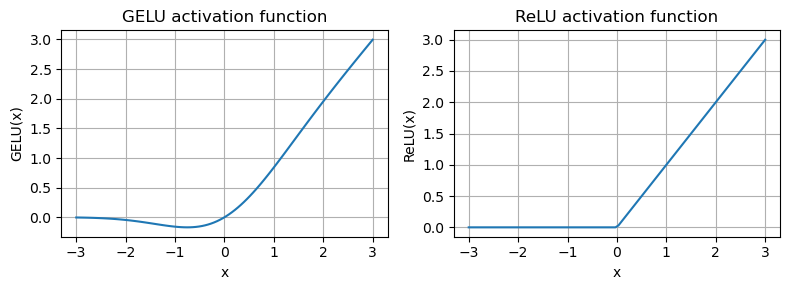

In [12]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y,label) in enumerate(zip([y_gelu, y_relu] , ["GELU", "ReLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# plays a crucial role in enhancing the model's ability to learn from and
# generalize the data. It internally expands the embedding dimension and then
# contract back. Such a design allows for the exploration of a richer 
# representation space
# the uniformity in input and output dimensions simplifies the architecture 
# by enabling stacking without the need to adjust dimensions between them, thus
# making the model more scalable

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self,x):
        return self.layers(x)

In [14]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [ ]:
# Adding shortcut connections (also known as skip or residual connections) 
# --> first goal: mitigate tge challenge of vanishing gradient
# Shortcut connections involve adding the inputs of a layer to its outputs, creating an
# alternate path that bypasses certain layers 

In [15]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                          GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [16]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [17]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()  # when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [18]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [19]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduces the projection dim to match the desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out,d_out) # Uses a Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        
        # We implicitly split the matrix by adding a num_heads dimension. Then 
        # we unroll the last dim: 
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim).
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(
            b, num_tokens, self.num_heads, self.head_dim
        )
        
        # Transposes from shape (b, num_tokens, num_heads, head_dim) to 
        # (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)
        
        # Computes dot product for each head
        attn_score = queries @ keys.transpose(2,3)
        # Masks truncated to the number of tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        # Uses the mask to fill attention scores
        attn_score.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(
            attn_score / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)
        
        # Tensor shape: (b, num_tokens, n_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1,2)
        
        # Combines heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        # Adds an optional linear projection
        context_vec = self.out_proj(context_vec)
        return context_vec

In [25]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        
        shortcut = x
        x = self.norm1(x)   # it's called "pre-layer norm"
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)  # applied to regularize the model and prevent from overfitting
        x = x + shortcut
        
        return x
        
        

In [27]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)


print("Input shape:", x.shape)
print("Output shape:", output.shape)

AttributeError: cannot assign module before Module.__init__() call

In [28]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
        

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

AttributeError: cannot assign module before Module.__init__() call

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 77,981,184
